In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.rc('figure',figsize=(17,13))
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
pyo.init_notebook_mode()


import re
import string 

import nltk
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk import pos_tag
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud
from tqdm.auto import tqdm

In [62]:
!pip install WordCloud

# EDA

In [63]:
df=pd.read_csv(r'tweets.csv')
df=df[:600]
df.head()

user_name                                               text   
0           Bohmle  #GPT4 for FREE. \nNo its not a clickbait, @Qol...  \
1              NaN                                      AI enthusiast   
2     Dan Bruno AI  ChatGPT Thinks These 5 Crypto Coins Will Explo...   
3  Georgiana Comsa  New: @JWVance's post about 5 #startups (includ...   
4     Bitone Great  🚨Get Out!🚨\n💰#Binance Spot💰\n⬇ Recommendation:...   

               user_location   
0                  Carkingga  \
1  2019-07-03 03:44:41+00:00   
2             Manchester, NH   
3                  Palo Alto   
4                  Hong Kong   

                                    user_description   
0                                                NaN  \
1                                               60.0   
2  The latest in #ChatGPT, #BARD, #Bing, and othe...   
3  Founder of Silicon Valley PR, award-winning PR...   
4  #ChatGPT (AI) powered Free Trading Signal! \nL...   

                user_created user_followers user_friends   
0                        NaN            NaN          NaN  \
1                      349.0            611        False   
2  2021-05-19 01:19:32+00:00          470.0        157.0   
3  2008-12-24 09:32:23+00:00         3864.0       1883.0   
4  2022-11-21 04:42:18+00:00         1517.0        506.0   

             user_favourites         user_verified                       date   
0                        NaN                   NaN                        NaN  \
1  2023-05-17 18:11:12+00:00  ['GPT4', 'ChatGPT4']            Twitter Web App   
2                       5185                 False  2023-05-17 18:11:03+00:00   
3                       2415                 False  2023-05-17 18:10:25+00:00   
4                         64                 False  2023-05-17 18:09:39+00:00   

                           hashtags           source  
0                               NaN              NaN  
1                               NaN              NaN  
2       ['chatgpt', 'AI', 'openAI']          dlvr.it  
3         ['startups', 'startup50']  Twitter Web App  
4  ['Binance', 'Short', 'GHSTUSDT']             rsi1

In [64]:
print('Rows              :',df.shape[0])
print('Columns           :',df.shape[1])
print('\nFeatures        :\n',df.columns.tolist())
print('\nMissing values  :',df.isna().sum().values.sum())
print('\nUnique values   :',df.nunique())

Rows              : 600
Columns           : 12

Features        :
 ['user_name', 'text', 'user_location', 'user_description', 'user_created', 'user_followers', 'user_friends', 'user_favourites', 'user_verified', 'date', 'hashtags', 'source']

Missing values  : 334

Unique values   : user_name           473
text                596
user_location       279
user_description    447
user_created        473
user_followers      382
user_friends        396
user_favourites     403
user_verified         2
date                561
hashtags            250
source               63
dtype: int64


In [65]:
!pip install vaderSentiment

# Pre processing and cleaning

In [66]:

def remove_line_breaks(text):
    text = text.replace('\r', ' ').replace('\n', ' ')
    return text

#remove punctuation
def remove_punctuation(text):
    re_replacements = re.compile("__[A-Z]+__")  # such as __NAME__, __LINK__
    re_punctuation = re.compile("[%s]" % re.escape(string.punctuation))
    '''Escape all the characters in pattern except ASCII letters and numbers'''
    tokens = word_tokenize(text)
    tokens_zero_punctuation = []
    for token in tokens:
        if not re_replacements.match(token):
            token = re_punctuation.sub(" ", token)
        tokens_zero_punctuation.append(token)
    return ' '.join(tokens_zero_punctuation)


def remove_special_characters(text):
    text = re.sub('[^a-zA-z0-9\s]', '', text)
    return text

def lowercase(text):
    text_low = [token.lower() for token in word_tokenize(text)]
    return ' '.join(text_low)

def remove_stopwords(text):
    stop = set(stopwords.words('english'))
    word_tokens = nltk.word_tokenize(text)
    text = " ".join([word for word in word_tokens if word not in stop])
    return text

def remove_one_character_words(text):
    '''Remove words from dataset that contain only 1 character'''
    text_high_use = [token for token in word_tokenize(text) if len(token)>1]      
    return ' '.join(text_high_use)   
    
#%%
# Stemming with 'Snowball stemmer" package
def stem(text):
    stemmer = nltk.stem.snowball.SnowballStemmer('english')
    text_stemmed = [stemmer.stem(token) for token in word_tokenize(text)]        
    return ' '.join(text_stemmed)

def lemma(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    word_tokens = nltk.word_tokenize(text)
    text_lemma = " ".join([wordnet_lemmatizer.lemmatize(word) for word in word_tokens])       
    return ' '.join(text_lemma)

def sentence_word(text):
    word_tokens = nltk.word_tokenize(text)
    return word_tokens
#break paragraphs to sentence token 
def paragraph_sentence(text):
    sent_token = nltk.sent_tokenize(text)
    return sent_token    

def tokenize(text):
    """Return a list of words in a text."""
    return re.findall(r'\w+', text)

def remove_numbers(text):
    no_nums = re.sub(r'\d+', '', text)
    return ''.join(no_nums)

def clean_text(text):
    _steps = [
    remove_line_breaks,
    remove_one_character_words,
    remove_special_characters,
    lowercase,
    remove_punctuation,
    remove_stopwords,
    stem,
    remove_numbers
]
    for step in _steps:
        text=step(text)
    return text   

In [67]:
df['text']=df['text'].astype(str)
df['text']=[x.replace(':',' ') for x in df['text']]

In [68]:
df['clean_text']=pd.Series([clean_text(i) for i in tqdm(df['text'])])

  0%|          | 0/600 [00:00<?, ?it/s]

In [69]:
df.loc[:,['text','clean_text']]

text   
0    #GPT4 for FREE. \nNo its not a clickbait, @Qol...  \
1                                        AI enthusiast   
2    ChatGPT Thinks These 5 Crypto Coins Will Explo...   
3    New  @JWVance's post about 5 #startups (includ...   
4    🚨Get Out!🚨\n💰#Binance Spot💰\n⬇ Recommendation ...   
..                                                 ...   
595  #DomainNameForSale \nhttps //t.co/ElyFcOXaux \...   
596  • Support for role-based chat models (e.g., #C...   
597  Global #GenerativeAI in #Healthcare Market Set...   
598  Leaving without comment. @OpenAI #ChatGPT http...   
599  Unleash the Power of AI  Discover the Exciting...   

                                            clean_text  
0    gpt free clickbait qolaba studio chatbot power...  
1                                        ai enthusiast  
2    chatgpt think crypto coin explod year yahoo fi...  
3    new jwvanc post startup includ vcinityinc st s...  
4    get binanc spot recommend short ticker ghstusd...  
..                                                 ...  
595  domainnameforsal https tcoelyfcoxaux readi rev...  
596  support rolebas chat model eg chatgpt easi int...  
597  global generativeai healthcar market set reach...  
598  leav without comment openai chatgpt https tcoh...  
599  unleash power ai discov excit world chatgpt pl...  

[600 rows x 2 columns]

In [70]:
words=df['clean_text'].values

In [71]:
ls=[]
for i in words:
    ls.append(str(i))

In [72]:
(pd.Series(nltk.ngrams(words, 2)).value_counts())[:10]

(gpt free clickbait qolaba studio chatbot power chatgpt offer chatgptplus free use along aiart generat allow click nft mint make aiartwork nfts openai openaichatgpt chatgpt, ai enthusiast)                                                                                                                                             1
(write ai help shift opinion https tcomipuxvrg ai generativeai chatgpt contentcr content contentwrit copywrit, video sam altman testimoni congress serv wakeup call potenti pitfal ai left us ensur futur technolog benefit human minim risk aiinsight responsibletech futurechalleng chatgpt https tcoqorulov)                          1
(thank share mvollmer interest cc jblefevre frronconi curieuxexplor nicochan khulood almani xbond enricomolinari leadership busi worklif success strategi innov futureofwork digitaltransform web ai chatgpt https tcoxyxeaq https tcookzunan, beyond potenti chatgpt major challeng ahead https tcohtqfwibhl talnupf lastus chatgpt)    1
(beyond

In [73]:
pd.Series(nltk.ngrams(words, 3)).value_counts()[:10]

(gpt free clickbait qolaba studio chatbot power chatgpt offer chatgptplus free use along aiart generat allow click nft mint make aiartwork nfts openai openaichatgpt chatgpt, ai enthusiast, chatgpt think crypto coin explod year yahoo financ chatgpt ai openai https tcotfoduqndz)                                                                                                                                                                                                                                                              1
(testimoni congress altman call establish new agenc licens ai technolog power revok licens compani abid govern rule full stori gt gt gt https tcodimhwt ai chatgpt aitechnolog jointheflyov https tcoghsflqxxd, write ai help shift opinion https tcomipuxvrg ai generativeai chatgpt contentcr content contentwrit copywrit, video sam altman testimoni congress serv wakeup call potenti pitfal ai left us ensur futur technolog benefit human minim risk aiinsight responsiblete

# Ngram analysis

In [74]:
bigrams_series = (pd.Series(nltk.ngrams(words, 2)).value_counts())[:10]
trigrams_series = (pd.Series(nltk.ngrams(words, 3)).value_counts())[:10]

Text(0.5, 0, '# of Occurances')

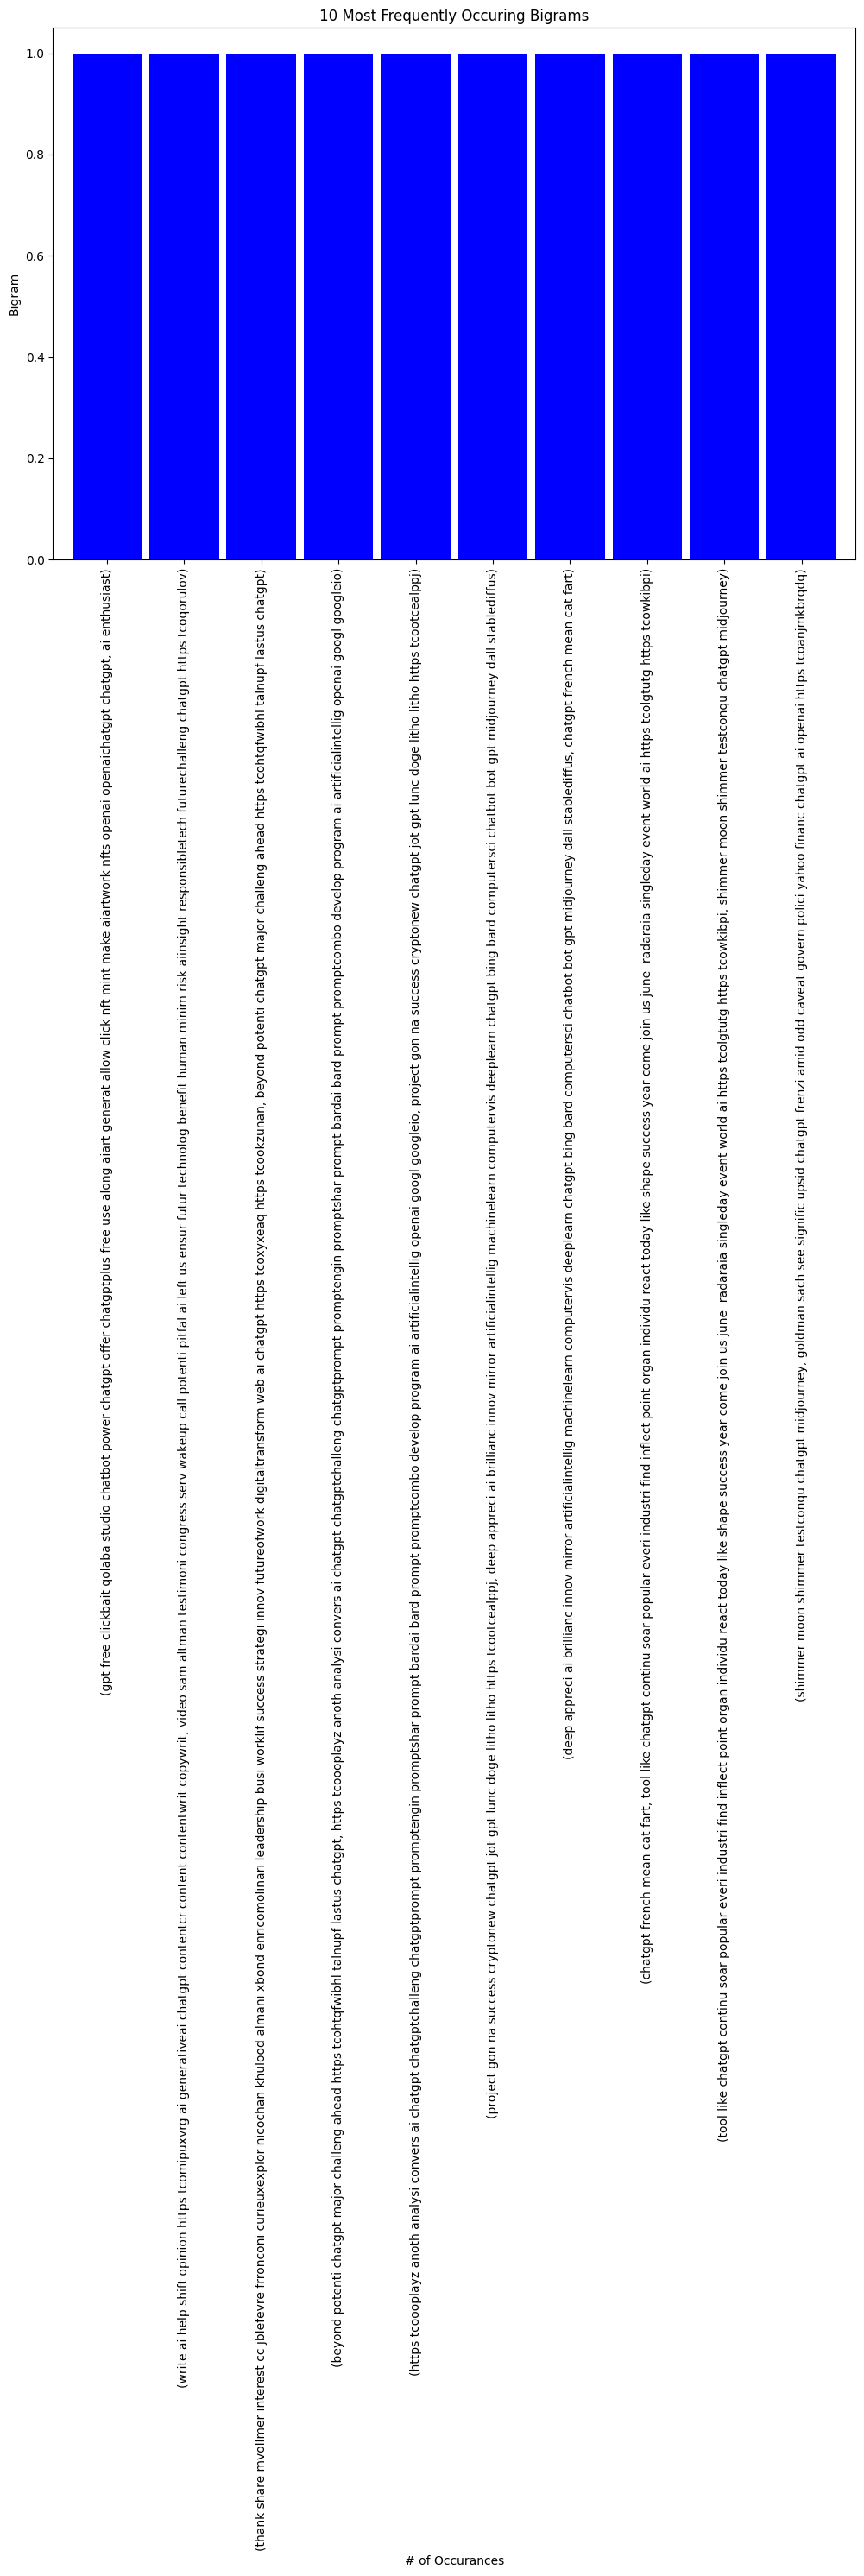

In [75]:
bigrams_series.sort_values().plot.bar(color='blue', width=.9, figsize=(12, 8))
plt.title('10 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# of Occurances')

Text(0.5, 0, '# of Occurances')

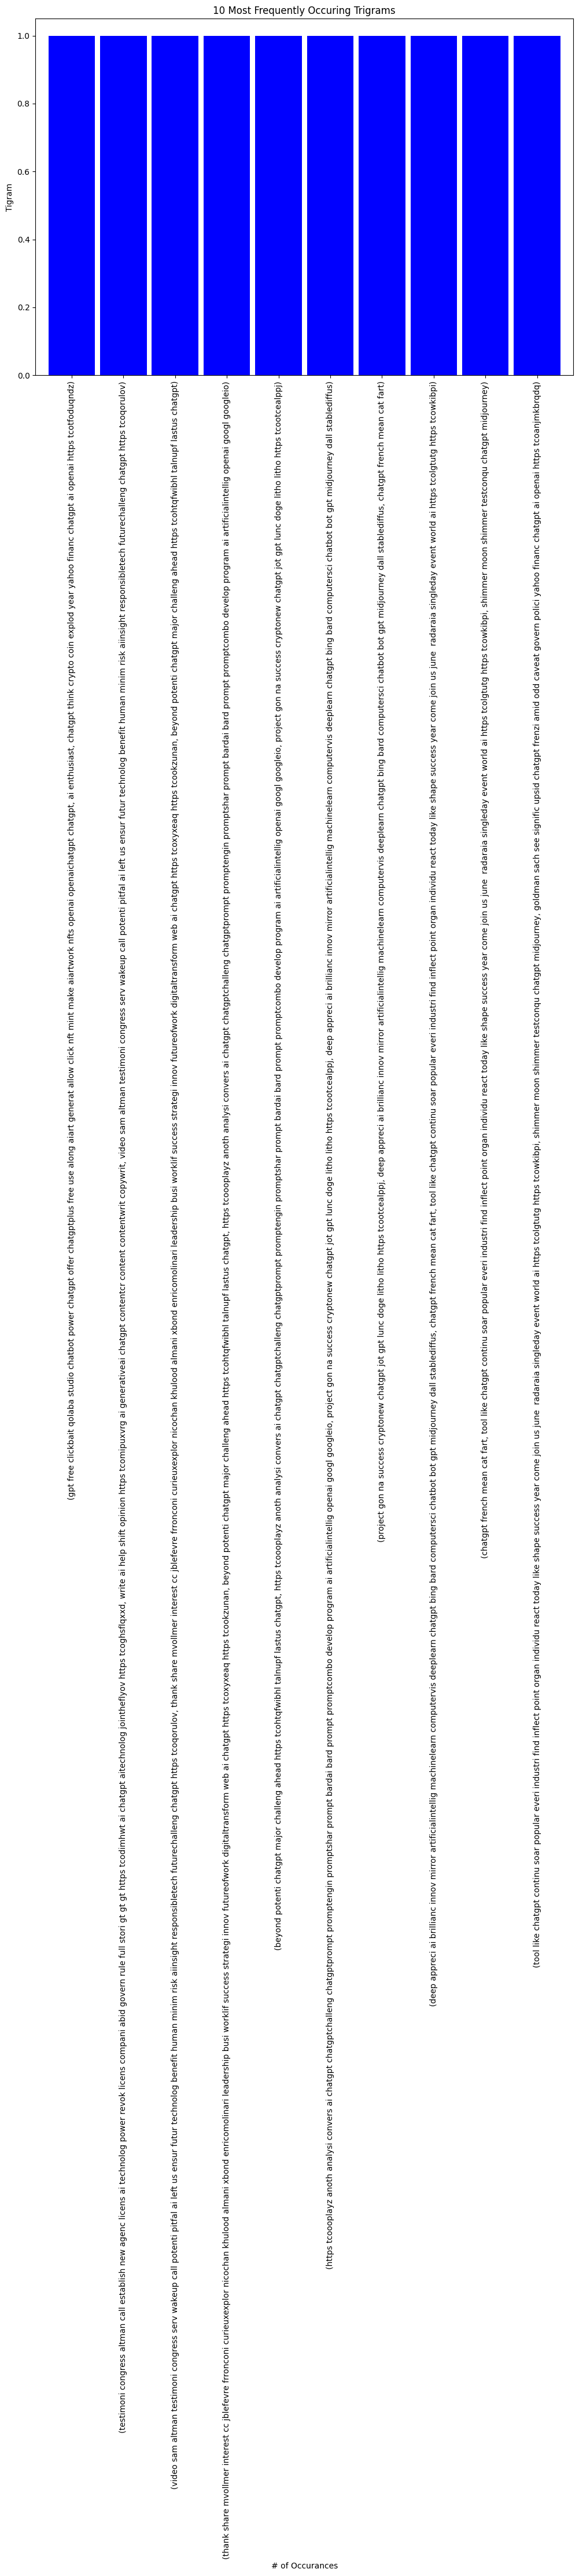

In [76]:
trigrams_series.sort_values().plot.bar(color='blue', width=.9, figsize=(12, 8))
plt.title('10 Most Frequently Occuring Trigrams')
plt.ylabel('Tigram')
plt.xlabel('# of Occurances')

# wordcloud

(-0.5, 1599.5, 799.5, -0.5)

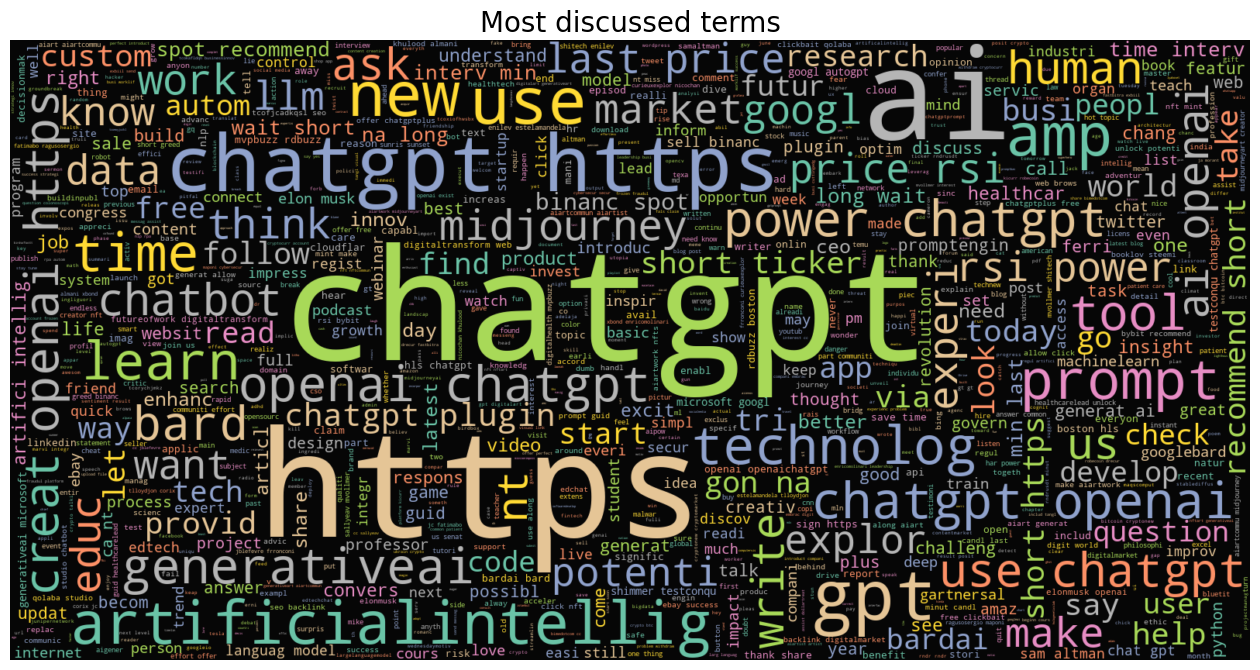

In [77]:
plt.figure(figsize=(16,13))
wc=WordCloud(background_color='black',colormap='Set2',max_words=1000,max_font_size=200,width=1600,height=800)
wc.generate(" ".join(ls))
plt.title('Most discussed terms',fontsize=20)
plt.imshow(wc.recolor(colormap='Set2',random_state=17),alpha=0.98,interpolation='bilinear')
plt.axis('off')

# sentiment analysis

In [78]:
from textblob import TextBlob
# Function to get the polarity of a text
def find_polarity(txt):
    '''
    A text argument is required. 
    The function returns a number between -1 and 1 which 
    is the polarity of the text
    '''
    blob = TextBlob(txt)
    return blob.sentences[0].sentiment.polarity

# Using the apply method to modify all the values in the column
df['polarity'] = df['text'].apply(find_polarity)
df

user_name   
0                        Bohmle  \
1                           NaN   
2                  Dan Bruno AI   
3               Georgiana Comsa   
4                  Bitone Great   
..                          ...   
595          Mazahir Abbas Shah   
596  BB / AI research and tools   
597      Enrico Molinari #MWC23   
598                       Mohit   
599            Daily Tech Notes   

                                                  text   
0    #GPT4 for FREE. \nNo its not a clickbait, @Qol...  \
1                                        AI enthusiast   
2    ChatGPT Thinks These 5 Crypto Coins Will Explo...   
3    New  @JWVance's post about 5 #startups (includ...   
4    🚨Get Out!🚨\n💰#Binance Spot💰\n⬇ Recommendation ...   
..                                                 ...   
595  #DomainNameForSale \nhttps //t.co/ElyFcOXaux \...   
596  • Support for role-based chat models (e.g., #C...   
597  Global #GenerativeAI in #Healthcare Market Set...   
598  Leaving without comment. @OpenAI #ChatGPT http...   
599  Unleash the Power of AI  Discover the Exciting...   

                 user_location   
0                    Carkingga  \
1    2019-07-03 03:44:41+00:00   
2               Manchester, NH   
3                    Palo Alto   
4                    Hong Kong   
..                         ...   
595                     Lahore   
596            Nunavut, Canada   
597           Global 🇮🇹 🇪🇺 🇺🇸    
598               Surat, India   
599              United States   

                                      user_description   
0                                                  NaN  \
1                                                 60.0   
2    The latest in #ChatGPT, #BARD, #Bing, and othe...   
3    Founder of Silicon Valley PR, award-winning PR...   
4    #ChatGPT (AI) powered Free Trading Signal! \nL...   
..                                                 ...   
595  IT Consultant, Domainer, Blogger and IT enthus...   
596  ML researcher under nda. Building and Reviewin...   
597  Head innovation & Tech Transfer @BNPParibas @H...   
598  It was always me versus the world Until I foun...   
599  🚀 Exploring the tech universe | DailyTechNotes...   

                  user_created user_followers user_friends   
0                          NaN            NaN          NaN  \
1                        349.0            611        False   
2    2021-05-19 01:19:32+00:00          470.0        157.0   
3    2008-12-24 09:32:23+00:00         3864.0       1883.0   
4    2022-11-21 04:42:18+00:00         1517.0        506.0   
..                         ...            ...          ...   
595  2015-11-15 06:41:57+00:00          603.0         56.0   
596  2022-11-22 22:47:59+00:00           93.0          2.0   
597  2009-09-19 23:55:41+00:00        49775.0       6899.0   
598  2012-06-15 15:20:25+00:00           70.0        318.0   
599  2023-04-24 22:52:40+00:00            1.0          1.0   

               user_favourites         user_verified   
0                          NaN                   NaN  \
1    2023-05-17 18:11:12+00:00  ['GPT4', 'ChatGPT4']   
2                         5185                 False   
3                         2415                 False   
4                           64                 False   
..                         ...                   ...   
595                        159                 False   
596                         32                 False   
597                      65269                 False   
598                      27234                 False   
599                          0                 False   

                          date                          hashtags   
0                          NaN                               NaN  \
1              Twitter Web App                               NaN   
2    2023-05-17 18:11:03+00:00       ['chatgpt', 'AI', 'openAI']   
3    2023-05-17 18:10:25+00:00         ['startups', 'startup50']   
4    2023-05-17 18:09:39+00:00  ['Binanc

In [79]:
def find_sentiment(txt):
        '''
        The function takes text argument and it returns sentiment which Positive, Neutral or Negative
        '''
        if find_polarity(txt) > 0:
            return 'Postitive'
        elif find_polarity(txt) == 0:
                return 'Neutral'
        elif find_polarity(txt) < 0:
            return 'Negative'
        else:
            pass

In [80]:
df['sentiments'] = df['text'].apply(find_sentiment)

df

user_name   
0                        Bohmle  \
1                           NaN   
2                  Dan Bruno AI   
3               Georgiana Comsa   
4                  Bitone Great   
..                          ...   
595          Mazahir Abbas Shah   
596  BB / AI research and tools   
597      Enrico Molinari #MWC23   
598                       Mohit   
599            Daily Tech Notes   

                                                  text   
0    #GPT4 for FREE. \nNo its not a clickbait, @Qol...  \
1                                        AI enthusiast   
2    ChatGPT Thinks These 5 Crypto Coins Will Explo...   
3    New  @JWVance's post about 5 #startups (includ...   
4    🚨Get Out!🚨\n💰#Binance Spot💰\n⬇ Recommendation ...   
..                                                 ...   
595  #DomainNameForSale \nhttps //t.co/ElyFcOXaux \...   
596  • Support for role-based chat models (e.g., #C...   
597  Global #GenerativeAI in #Healthcare Market Set...   
598  Leaving without comment. @OpenAI #ChatGPT http...   
599  Unleash the Power of AI  Discover the Exciting...   

                 user_location   
0                    Carkingga  \
1    2019-07-03 03:44:41+00:00   
2               Manchester, NH   
3                    Palo Alto   
4                    Hong Kong   
..                         ...   
595                     Lahore   
596            Nunavut, Canada   
597           Global 🇮🇹 🇪🇺 🇺🇸    
598               Surat, India   
599              United States   

                                      user_description   
0                                                  NaN  \
1                                                 60.0   
2    The latest in #ChatGPT, #BARD, #Bing, and othe...   
3    Founder of Silicon Valley PR, award-winning PR...   
4    #ChatGPT (AI) powered Free Trading Signal! \nL...   
..                                                 ...   
595  IT Consultant, Domainer, Blogger and IT enthus...   
596  ML researcher under nda. Building and Reviewin...   
597  Head innovation & Tech Transfer @BNPParibas @H...   
598  It was always me versus the world Until I foun...   
599  🚀 Exploring the tech universe | DailyTechNotes...   

                  user_created user_followers user_friends   
0                          NaN            NaN          NaN  \
1                        349.0            611        False   
2    2021-05-19 01:19:32+00:00          470.0        157.0   
3    2008-12-24 09:32:23+00:00         3864.0       1883.0   
4    2022-11-21 04:42:18+00:00         1517.0        506.0   
..                         ...            ...          ...   
595  2015-11-15 06:41:57+00:00          603.0         56.0   
596  2022-11-22 22:47:59+00:00           93.0          2.0   
597  2009-09-19 23:55:41+00:00        49775.0       6899.0   
598  2012-06-15 15:20:25+00:00           70.0        318.0   
599  2023-04-24 22:52:40+00:00            1.0          1.0   

               user_favourites         user_verified   
0                          NaN                   NaN  \
1    2023-05-17 18:11:12+00:00  ['GPT4', 'ChatGPT4']   
2                         5185                 False   
3                         2415                 False   
4                           64                 False   
..                         ...                   ...   
595                        159                 False   
596                         32                 False   
597                      65269                 False   
598                      27234                 False   
599                          0                 False   

                          date                          hashtags   
0                          NaN                               NaN  \
1              Twitter Web App                               NaN   
2    2023-05-17 18:11:03+00:00       ['chatgpt', 'AI', 'openAI']   
3    2023-05-17 18:10:25+00:00         ['startups', 'startup50']   
4    2023-05-17 18:09:39+00:00  ['Binanc

In [81]:
values = df['sentiments'].value_counts().values
indexes = df['sentiments'].value_counts().index

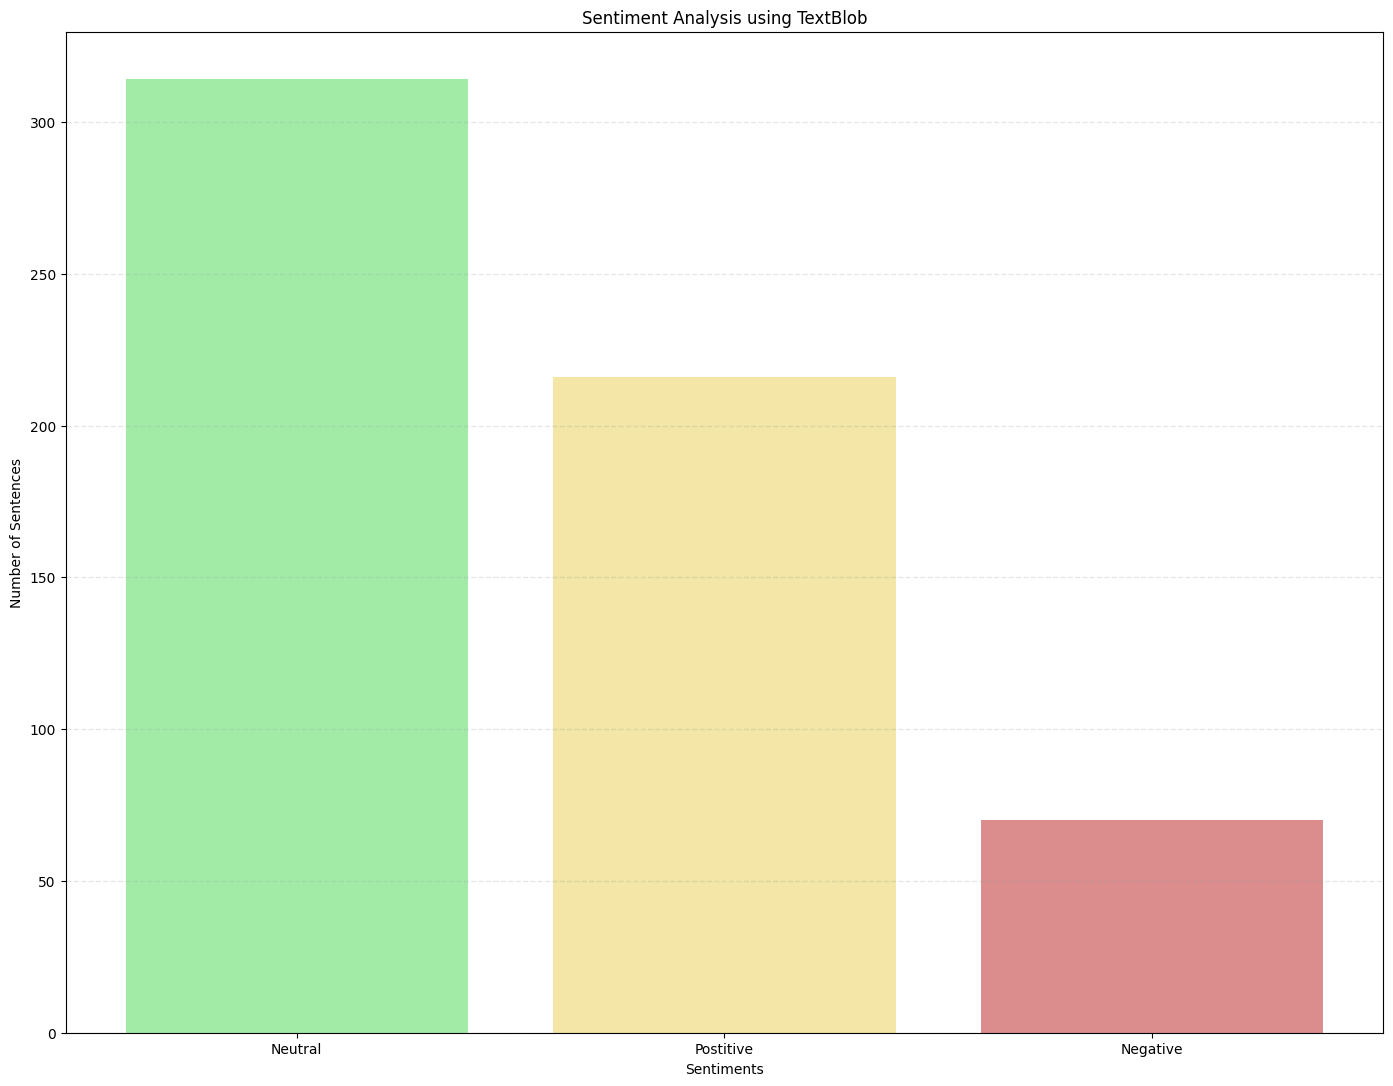

In [82]:
plt.title('Sentiment Analysis using TextBlob')
plt.xlabel('Sentiments')
plt.ylabel('Number of Sentences')
# plt.legend(indexes)
plt.bar(indexes, values,color=['#7be382','#eedc82', '#cd5c5c'], alpha = 0.7)
plt.grid(color='#95a5a6', linestyle='--', linewidth=1, axis='y', alpha=0.25)

plt.show()

# feature engineering

In [83]:
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize

count=0
l=[]
words=[]
spaces=[]
verbs=[]
for i in df['clean_text']:
    l.append(len(i))
    words.append(len(str(i).split()))
    spaces.append(len(str(i).split())-1)
    for i,j in pos_tag(word_tokenize(i)):
        if j=="verb":
            count=count+1
    verbs.append(count)       

df['length']=l
df['words']=words
df['spaces']=spaces
df['verbs']=verbs
df


user_name   
0                        Bohmle  \
1                           NaN   
2                  Dan Bruno AI   
3               Georgiana Comsa   
4                  Bitone Great   
..                          ...   
595          Mazahir Abbas Shah   
596  BB / AI research and tools   
597      Enrico Molinari #MWC23   
598                       Mohit   
599            Daily Tech Notes   

                                                  text   
0    #GPT4 for FREE. \nNo its not a clickbait, @Qol...  \
1                                        AI enthusiast   
2    ChatGPT Thinks These 5 Crypto Coins Will Explo...   
3    New  @JWVance's post about 5 #startups (includ...   
4    🚨Get Out!🚨\n💰#Binance Spot💰\n⬇ Recommendation ...   
..                                                 ...   
595  #DomainNameForSale \nhttps //t.co/ElyFcOXaux \...   
596  • Support for role-based chat models (e.g., #C...   
597  Global #GenerativeAI in #Healthcare Market Set...   
598  Leaving without comment. @OpenAI #ChatGPT http...   
599  Unleash the Power of AI  Discover the Exciting...   

                 user_location   
0                    Carkingga  \
1    2019-07-03 03:44:41+00:00   
2               Manchester, NH   
3                    Palo Alto   
4                    Hong Kong   
..                         ...   
595                     Lahore   
596            Nunavut, Canada   
597           Global 🇮🇹 🇪🇺 🇺🇸    
598               Surat, India   
599              United States   

                                      user_description   
0                                                  NaN  \
1                                                 60.0   
2    The latest in #ChatGPT, #BARD, #Bing, and othe...   
3    Founder of Silicon Valley PR, award-winning PR...   
4    #ChatGPT (AI) powered Free Trading Signal! \nL...   
..                                                 ...   
595  IT Consultant, Domainer, Blogger and IT enthus...   
596  ML researcher under nda. Building and Reviewin...   
597  Head innovation & Tech Transfer @BNPParibas @H...   
598  It was always me versus the world Until I foun...   
599  🚀 Exploring the tech universe | DailyTechNotes...   

                  user_created user_followers user_friends   
0                          NaN            NaN          NaN  \
1                        349.0            611        False   
2    2021-05-19 01:19:32+00:00          470.0        157.0   
3    2008-12-24 09:32:23+00:00         3864.0       1883.0   
4    2022-11-21 04:42:18+00:00         1517.0        506.0   
..                         ...            ...          ...   
595  2015-11-15 06:41:57+00:00          603.0         56.0   
596  2022-11-22 22:47:59+00:00           93.0          2.0   
597  2009-09-19 23:55:41+00:00        49775.0       6899.0   
598  2012-06-15 15:20:25+00:00           70.0        318.0   
599  2023-04-24 22:52:40+00:00            1.0          1.0   

               user_favourites         user_verified   
0                          NaN                   NaN  \
1    2023-05-17 18:11:12+00:00  ['GPT4', 'ChatGPT4']   
2                         5185                 False   
3                         2415                 False   
4                           64                 False   
..                         ...                   ...   
595                        159                 False   
596                         32                 False   
597                      65269                 False   
598                      27234                 False   
599                          0                 False   

                          date                          hashtags   
0                          NaN                               NaN  \
1              Twitter Web App                               NaN   
2    2023-05-17 18:11:03+00:00       ['chatgpt', 'AI', 'openAI']   
3    2023-05-17 18:10:25+00:00         ['startups', 'startup50']   
4    2023-05-17 18:09:39+00:00  ['Binanc

# applying count vectorizer and tfidf vectorizer and storing them as columns in existing datframe

In [84]:
from sklearn.feature_extraction.text import CountVectorizer
bow=CountVectorizer(stop_words='english',max_features=200)

In [85]:
bow.fit(df.text)

CountVectorizer(max_features=200, stop_words='english')

In [86]:
X=bow.fit_transform(df.text).toarray()

In [87]:
count

0

In [88]:
df['countvect']=bow

In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer()
df['Tf-Idf']=v
x = v.fit_transform(df['text'])

In [90]:
df

user_name   
0                        Bohmle  \
1                           NaN   
2                  Dan Bruno AI   
3               Georgiana Comsa   
4                  Bitone Great   
..                          ...   
595          Mazahir Abbas Shah   
596  BB / AI research and tools   
597      Enrico Molinari #MWC23   
598                       Mohit   
599            Daily Tech Notes   

                                                  text   
0    #GPT4 for FREE. \nNo its not a clickbait, @Qol...  \
1                                        AI enthusiast   
2    ChatGPT Thinks These 5 Crypto Coins Will Explo...   
3    New  @JWVance's post about 5 #startups (includ...   
4    🚨Get Out!🚨\n💰#Binance Spot💰\n⬇ Recommendation ...   
..                                                 ...   
595  #DomainNameForSale \nhttps //t.co/ElyFcOXaux \...   
596  • Support for role-based chat models (e.g., #C...   
597  Global #GenerativeAI in #Healthcare Market Set...   
598  Leaving without comment. @OpenAI #ChatGPT http...   
599  Unleash the Power of AI  Discover the Exciting...   

                 user_location   
0                    Carkingga  \
1    2019-07-03 03:44:41+00:00   
2               Manchester, NH   
3                    Palo Alto   
4                    Hong Kong   
..                         ...   
595                     Lahore   
596            Nunavut, Canada   
597           Global 🇮🇹 🇪🇺 🇺🇸    
598               Surat, India   
599              United States   

                                      user_description   
0                                                  NaN  \
1                                                 60.0   
2    The latest in #ChatGPT, #BARD, #Bing, and othe...   
3    Founder of Silicon Valley PR, award-winning PR...   
4    #ChatGPT (AI) powered Free Trading Signal! \nL...   
..                                                 ...   
595  IT Consultant, Domainer, Blogger and IT enthus...   
596  ML researcher under nda. Building and Reviewin...   
597  Head innovation & Tech Transfer @BNPParibas @H...   
598  It was always me versus the world Until I foun...   
599  🚀 Exploring the tech universe | DailyTechNotes...   

                  user_created user_followers user_friends   
0                          NaN            NaN          NaN  \
1                        349.0            611        False   
2    2021-05-19 01:19:32+00:00          470.0        157.0   
3    2008-12-24 09:32:23+00:00         3864.0       1883.0   
4    2022-11-21 04:42:18+00:00         1517.0        506.0   
..                         ...            ...          ...   
595  2015-11-15 06:41:57+00:00          603.0         56.0   
596  2022-11-22 22:47:59+00:00           93.0          2.0   
597  2009-09-19 23:55:41+00:00        49775.0       6899.0   
598  2012-06-15 15:20:25+00:00           70.0        318.0   
599  2023-04-24 22:52:40+00:00            1.0          1.0   

               user_favourites         user_verified   
0                          NaN                   NaN  \
1    2023-05-17 18:11:12+00:00  ['GPT4', 'ChatGPT4']   
2                         5185                 False   
3                         2415                 False   
4                           64                 False   
..                         ...                   ...   
595                        159                 False   
596                         32                 False   
597                      65269                 False   
598                      27234                 False   
599                          0                 False   

                          date  ...              source   
0                          NaN  ...                 NaN  \
1              Twitter Web App  ...                 NaN   
2    2023-05-17 18:11:03+00:00  ...             dlvr.it   
3    2023-05-17 18:10:25+00:00  ...     Twitter Web App   
4    2023-05-17 18:09:39+00:00  ...                rsi1   
..                        

# corelation

In [91]:
import pandas as pd
import numpy as np

rs = np.random.RandomState(0)
dfs = pd.DataFrame(rs.rand(10, 10))
corr = dfs.corr()
corr.style.background_gradient(cmap='coolwarm')
# 'RdBu_r', 'BrBG_r', & PuOr_r are other good diverging colormaps

In [93]:
corr_matrix = dfs.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
upper

0         1         2         3         4         5         6         7   
0 NaN  0.347533  0.398948  0.455743  0.072914  0.233402  0.731222  0.477978  \
1 NaN       NaN  0.284056  0.571003  0.285483  0.382480  0.362842  0.642578   
2 NaN       NaN       NaN  0.523649  0.152937  0.139176  0.092895  0.016266   
3 NaN       NaN       NaN       NaN  0.225343  0.227577  0.481548  0.473286   
4 NaN       NaN       NaN       NaN       NaN  0.104438  0.147477  0.523283   
5 NaN       NaN       NaN       NaN       NaN       NaN  0.030252  0.417640   
6 NaN       NaN       NaN       NaN       NaN       NaN       NaN  0.494440   
7 NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
8 NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
9 NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

          8         9  
0  0.442621  0.015185  
1  0.252556  0.190047  
2  0.434016  0.383585  
3  0.279258  0.446650  
4  0.614603  0.189916  
5  0.205851  0.095084  
6  0.381407  0.353652  
7  0.375873  0.417863  
8       NaN  0.150421  
9       NaN       NaN

# Model training

In [94]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

In [95]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

In [96]:
df

user_name   
0                        Bohmle  \
1                           NaN   
2                  Dan Bruno AI   
3               Georgiana Comsa   
4                  Bitone Great   
..                          ...   
595          Mazahir Abbas Shah   
596  BB / AI research and tools   
597      Enrico Molinari #MWC23   
598                       Mohit   
599            Daily Tech Notes   

                                                  text   
0    #GPT4 for FREE. \nNo its not a clickbait, @Qol...  \
1                                        AI enthusiast   
2    ChatGPT Thinks These 5 Crypto Coins Will Explo...   
3    New  @JWVance's post about 5 #startups (includ...   
4    🚨Get Out!🚨\n💰#Binance Spot💰\n⬇ Recommendation ...   
..                                                 ...   
595  #DomainNameForSale \nhttps //t.co/ElyFcOXaux \...   
596  • Support for role-based chat models (e.g., #C...   
597  Global #GenerativeAI in #Healthcare Market Set...   
598  Leaving without comment. @OpenAI #ChatGPT http...   
599  Unleash the Power of AI  Discover the Exciting...   

                 user_location   
0                    Carkingga  \
1    2019-07-03 03:44:41+00:00   
2               Manchester, NH   
3                    Palo Alto   
4                    Hong Kong   
..                         ...   
595                     Lahore   
596            Nunavut, Canada   
597           Global 🇮🇹 🇪🇺 🇺🇸    
598               Surat, India   
599              United States   

                                      user_description   
0                                                  NaN  \
1                                                 60.0   
2    The latest in #ChatGPT, #BARD, #Bing, and othe...   
3    Founder of Silicon Valley PR, award-winning PR...   
4    #ChatGPT (AI) powered Free Trading Signal! \nL...   
..                                                 ...   
595  IT Consultant, Domainer, Blogger and IT enthus...   
596  ML researcher under nda. Building and Reviewin...   
597  Head innovation & Tech Transfer @BNPParibas @H...   
598  It was always me versus the world Until I foun...   
599  🚀 Exploring the tech universe | DailyTechNotes...   

                  user_created user_followers user_friends   
0                          NaN            NaN          NaN  \
1                        349.0            611        False   
2    2021-05-19 01:19:32+00:00          470.0        157.0   
3    2008-12-24 09:32:23+00:00         3864.0       1883.0   
4    2022-11-21 04:42:18+00:00         1517.0        506.0   
..                         ...            ...          ...   
595  2015-11-15 06:41:57+00:00          603.0         56.0   
596  2022-11-22 22:47:59+00:00           93.0          2.0   
597  2009-09-19 23:55:41+00:00        49775.0       6899.0   
598  2012-06-15 15:20:25+00:00           70.0        318.0   
599  2023-04-24 22:52:40+00:00            1.0          1.0   

               user_favourites         user_verified   
0                          NaN                   NaN  \
1    2023-05-17 18:11:12+00:00  ['GPT4', 'ChatGPT4']   
2                         5185                 False   
3                         2415                 False   
4                           64                 False   
..                         ...                   ...   
595                        159                 False   
596                         32                 False   
597                      65269                 False   
598                      27234                 False   
599                          0                 False   

                          date  ...              source   
0                          NaN  ...                 NaN  \
1              Twitter Web App  ...                 NaN   
2    2023-05-17 18:11:03+00:00  ...             dlvr.it   
3    2023-05-17 18:10:25+00:00  ...     Twitter Web App   
4    2023-05-17 18:09:39+00:00  ...                rsi1   
..                        

In [139]:
Y=df['sentiments']

In [140]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=12)

In [141]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

In [154]:
models = [
    ("LinearSVC", LinearSVC()),
    ("MultinomialNB", MultinomialNB()),
    ("Random Forest", RandomForestClassifier(n_estimators=100))
    
]

In [155]:
# Train and evaluate models on the TF-IDF vectors
for name, model in models:
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    print(f"Model: {name}\n{classification_report(Y_test, y_pred)}\n")

Model: LinearSVC
              precision    recall  f1-score   support

    Negative       0.27      0.23      0.25        13
     Neutral       0.62      0.70      0.66        61
   Postitive       0.55      0.48      0.51        46

    accuracy                           0.57       120
   macro avg       0.48      0.47      0.47       120
weighted avg       0.56      0.57      0.56       120


Model: MultinomialNB
              precision    recall  f1-score   support

    Negative       0.30      0.23      0.26        13
     Neutral       0.66      0.62      0.64        61
   Postitive       0.52      0.59      0.55        46

    accuracy                           0.57       120
   macro avg       0.49      0.48      0.48       120
weighted avg       0.56      0.57      0.56       120


Model: Random Forest
              precision    recall  f1-score   support

    Negative       0.75      0.23      0.35        13
     Neutral       0.65      0.67      0.66        61
   Postitive  